In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn vowpal_wabbit

ERROR: Could not find a version that satisfies the requirement vowpal_wabbit (from versions: none)
ERROR: No matching distribution found for vowpal_wabbit


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import random
from collections import defaultdict
import time

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Setting up the environment and downloading the MovieLens dataset...")

# Download the MovieLens dataset (small version)
!wget -q https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip -q ml-latest-small.zip

print("Dataset downloaded successfully!")

# Load the MovieLens dataset
movies_df = pd.read_csv('ml-latest-small/movies.csv')
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
tags_df = pd.read_csv('ml-latest-small/tags.csv')

print(f"Loaded {len(movies_df)} movies and {len(ratings_df)} ratings")

# Basic data exploration
print("\nMovie data sample:")
print(movies_df.head())

print("\nRatings data sample:")
print(ratings_df.head())

# Extract movie genres and convert to binary features
print("\nPreprocessing movie genres...")
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)$').astype(float)
movies_df['genres'] = movies_df['genres'].str.split('|')
genres = set()
for genre_list in movies_df['genres']:
    if isinstance(genre_list, list):
        genres.update(genre_list)
genres = sorted(list(genres))

# Create binary genre features
for genre in genres:
    movies_df[f'genre_{genre}'] = movies_df['genres'].apply(
        lambda x: 1 if isinstance(x, list) and genre in x else 0
    )

# Process user data for context
print("Processing user context data...")
# Calculate average rating per user and number of ratings
user_context = ratings_df.groupby('userId').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

# Add recency feature - when was the user last active
latest_rating = ratings_df.groupby('userId')['timestamp'].max().reset_index()
latest_rating.columns = ['userId', 'latest_timestamp']
user_context = user_context.merge(latest_rating, on='userId', how='left')

# Normalize features
scaler = StandardScaler()
user_context[['avg_rating', 'num_ratings', 'latest_timestamp']] = scaler.fit_transform(
    user_context[['avg_rating', 'num_ratings', 'latest_timestamp']]
)

print("User context sample:")
print(user_context.head())

# Create movie clusters to represent "campaigns" (simulating email campaigns)
# We'll create 10 "campaign groups" (movie clusters) to choose from
print("\nCreating movie campaign clusters...")
from sklearn.cluster import KMeans

# Select numeric features for clustering
movie_features = movies_df[[col for col in movies_df.columns if col.startswith('genre_') or col == 'year']]
movie_features = movie_features.fillna(0)

# Create 10 clusters (representing different marketing campaigns)
kmeans = KMeans(n_clusters=10, random_state=42)
movies_df['campaign_cluster'] = kmeans.fit_predict(movie_features)

print("Movie campaign clusters created. Distribution:")
print(movies_df['campaign_cluster'].value_counts())

Setting up the environment and downloading the MovieLens dataset...
Dataset downloaded successfully!
Loaded 9742 movies and 100836 ratings

Movie data sample:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings data sample:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982

In [ ]:
# ===================== CONTEXTUAL BANDIT IMPLEMENTATION ===================== #
print("\n===== CONTEXTUAL BANDIT IMPLEMENTATION =====")
print("Implementing LinUCB algorithm...")

class LinUCBArm:
    """
    LinUCB arm implementation for contextual bandits
    """
    def __init__(self, arm_index, d, alpha):
        """
        Initialize a LinUCB arm

        Parameters:
        - arm_index: index of this arm (campaign ID)
        - d: dimension of the context vector
        - alpha: exploration parameter
        """
        # A is the matrix to estimate the unknown parameter theta
        self.A = np.identity(d)
        # b is the vector to store the rewards
        self.b = np.zeros(d)
        # Store the arm index
        self.arm_index = arm_index
        # Alpha is the exploration parameter
        self.alpha = alpha
        # Dimension of the context
        self.d = d

    def get_reward_estimate(self, x):
        """
        Get the estimated reward for this arm given context x

        Parameters:
        - x: context vector

        Returns:
        - estimated reward and confidence bound
        """
        # Calculate the inverse of A
        A_inv = np.linalg.inv(self.A)

        # Estimate of the expected reward (theta^T * x)
        theta = A_inv.dot(self.b)
        reward_estimate = theta.dot(x)

        # Confidence bound
        cb = self.alpha * np.sqrt(x.dot(A_inv).dot(x))

        # Upper confidence bound
        ucb = reward_estimate + cb

        return ucb, reward_estimate

    def update(self, x, reward):
        """
        Update the model after receiving a reward

        Parameters:
        - x: context vector
        - reward: observed reward
        """
        # Update A matrix
        self.A += np.outer(x, x)

        # Update b vector
        self.b += reward * x

class LinUCBPolicy:
    """
    LinUCB policy implementation for contextual bandits
    """
    def __init__(self, n_arms, d, alpha=1.0):
        """
        Initialize the LinUCB policy

        Parameters:
        - n_arms: number of arms (campaigns)
        - d: dimension of the context vector
        - alpha: exploration parameter
        """
        self.arms = [LinUCBArm(i, d, alpha) for i in range(n_arms)]
        self.n_arms = n_arms
        self.d = d

    def select_arm(self, context):
        """
        Select an arm (campaign) based on the context

        Parameters:
        - context: context vector

        Returns:
        - selected arm index
        """
        # Get the UCB values for all arms
        ucb_values = np.zeros(self.n_arms)
        reward_estimates = np.zeros(self.n_arms)

        for arm_idx in range(self.n_arms):
            ucb_values[arm_idx], reward_estimates[arm_idx] = self.arms[arm_idx].get_reward_estimate(context)

        # Select the arm with the highest UCB value
        selected_arm = np.argmax(ucb_values)
        return selected_arm, ucb_values, reward_estimates

    def update(self, arm_idx, context, reward):
        """
        Update the selected arm with the observed reward

        Parameters:
        - arm_idx: index of the selected arm
        - context: context vector
        - reward: observed reward
        """
        self.arms[arm_idx].update(context, reward)



===== CONTEXTUAL BANDIT IMPLEMENTATION =====
Implementing LinUCB algorithm...


In [ ]:
# ===================== SIMULATION ENVIRONMENT ===================== #
print("\n===== SETTING UP SIMULATION ENVIRONMENT =====")
print("Creating simulation for marketing campaign optimization...")

class MarketingCampaignSimulator:
    """
    Simulator for marketing campaigns using the MovieLens dataset
    """
    def __init__(self, users_df, movies_df, ratings_df, context_dim=13):
        """
        Initialize the simulator

        Parameters:
        - users_df: DataFrame with user information
        - movies_df: DataFrame with movie information
        - ratings_df: DataFrame with rating information
        - context_dim: dimension of the context vector
        """
        self.users_df = users_df
        self.movies_df = movies_df
        self.ratings_df = ratings_df
        self.context_dim = context_dim

        # Group movies by campaign clusters
        self.campaign_movies = defaultdict(list)
        for _, row in movies_df.iterrows():
            self.campaign_movies[row['campaign_cluster']].append(row['movieId'])

        # Create user preference model
        self.user_preferences = self._create_user_preference_model()

    def _create_user_preference_model(self):
        """
        Create a preference model for each user based on their ratings

        Returns:
        - Dictionary mapping user_id to their genre preferences
        """
        user_preferences = {}

        # For each user, calculate their average rating for each genre
        for user_id in self.users_df['userId'].unique():
            # Get user ratings
            user_ratings = self.ratings_df[self.ratings_df['userId'] == user_id]

            if len(user_ratings) == 0:
                continue

            # Create preference vector (average rating per genre)
            genre_ratings = defaultdict(list)

            for _, rating in user_ratings.iterrows():
                movie_id = rating['movieId']
                movie_row = self.movies_df[self.movies_df['movieId'] == movie_id]

                if len(movie_row) == 0:
                    continue

                # Get the movie genres
                for genre in genres:
                    genre_col = f'genre_{genre}'
                    if genre_col in movie_row.columns:
                        genre_val = movie_row[genre_col].values[0]
                        if genre_val == 1:
                            genre_ratings[genre].append(rating['rating'])

            # Calculate average rating per genre
            genre_avg_ratings = {}
            for genre, ratings in genre_ratings.items():
                if ratings:
                    genre_avg_ratings[genre] = sum(ratings) / len(ratings)

            user_preferences[user_id] = genre_avg_ratings

        return user_preferences

    def get_user_context(self, user_id):
        """
        Get the context vector for a user

        Parameters:
        - user_id: user ID

        Returns:
        - context vector
        """
        # Get user row
        user_row = self.users_df[self.users_df['userId'] == user_id]

        if len(user_row) == 0:
            # If user not found, return zero context
            return np.zeros(self.context_dim)

        # Basic user features
        context = [
            user_row['avg_rating'].values[0],
            user_row['num_ratings'].values[0],
            user_row['latest_timestamp'].values[0]
        ]

        # Add genre preferences
        if user_id in self.user_preferences:
            for genre in genres:
                if genre in self.user_preferences[user_id]:
                    context.append(self.user_preferences[user_id][genre])
                else:
                    context.append(0)
        else:
            # If no preference data, append zeros
            context.extend([0] * len(genres))

        # Ensure context has the right dimension
        if len(context) < self.context_dim:
            context.extend([0] * (self.context_dim - len(context)))
        elif len(context) > self.context_dim:
            context = context[:self.context_dim]

        return np.array(context)

    def get_reward(self, user_id, campaign_id):
        """
        Simulate the reward for showing a campaign to a user

        Parameters:
        - user_id: user ID
        - campaign_id: campaign ID

        Returns:
        - reward value (click/engagement probability)
        """
        # Get movies in this campaign
        movies_in_campaign = self.campaign_movies[campaign_id]

        if not movies_in_campaign:
            return 0.0

        # For this simulation, we'll use the user's ratings of movies in this cluster
        # to determine how much they would like this campaign
        user_ratings = self.ratings_df[
            (self.ratings_df['userId'] == user_id) &
            (self.ratings_df['movieId'].isin(movies_in_campaign))
        ]

        if len(user_ratings) == 0:
            # If user hasn't rated any movies in this cluster, use a default reward
            # based on the average rating of all movies in this cluster
            cluster_ratings = self.ratings_df[
                self.ratings_df['movieId'].isin(movies_in_campaign)
            ]

            if len(cluster_ratings) > 0:
                avg_cluster_rating = cluster_ratings['rating'].mean() / 5.0  # Normalize to [0,1]
                # Add some noise to simulate variability
                reward = avg_cluster_rating * 0.8 + 0.1 * np.random.random()
            else:
                # If no ratings for this cluster, use a random baseline reward
                reward = 0.2 * np.random.random()
        else:
            # Calculate the average rating for this user for this campaign's movies
            avg_user_rating = user_ratings['rating'].mean() / 5.0  # Normalize to [0,1]

            # Add some noise to simulate variability
            reward = avg_user_rating * 0.8 + 0.2 * np.random.random()

        # Clip reward to [0,1]
        # (representing probability of clicking or engaging with the campaign)
        return max(0, min(1, reward))


===== SETTING UP SIMULATION ENVIRONMENT =====
Creating simulation for marketing campaign optimization...


In [ ]:
# ===================== TRAINING AND EVALUATION ===================== #
print("\n===== SETTING UP TRAINING AND EVALUATION =====")

# Set up the simulator
context_dim = 3 + len(genres)  # user features + genre preferences
n_campaigns = 10  # Number of campaign clusters

simulator = MarketingCampaignSimulator(
    user_context,
    movies_df,
    ratings_df,
    context_dim=context_dim
)

# Set up the contextual bandit algorithm
linucb = LinUCBPolicy(n_arms=n_campaigns, d=context_dim, alpha=1.0)

# Set up for simulation
n_iterations = 10000
user_ids = user_context['userId'].values
total_rewards = 0
rewards_history = []
avg_rewards_history = []
selected_arms_history = []
arm_selection_counts = [0] * n_campaigns

print(f"Training the contextual bandit for {n_iterations} iterations...")

# Run the simulation
for i in range(n_iterations):
    # Randomly select a user
    user_id = np.random.choice(user_ids)

    # Get context for this user
    context = simulator.get_user_context(user_id)

    # Select a campaign using the policy
    arm_idx, ucb_values, reward_estimates = linucb.select_arm(context)
    selected_arms_history.append(arm_idx)
    arm_selection_counts[arm_idx] += 1

    # Get reward (simulated user response)
    reward = simulator.get_reward(user_id, arm_idx)

    # Update policy with the observed reward
    linucb.update(arm_idx, context, reward)

    # Track rewards
    total_rewards += reward
    rewards_history.append(reward)
    avg_rewards_history.append(total_rewards / (i + 1))

    # Print progress
    if (i + 1) % 1000 == 0:
        print(f"Iteration {i+1}/{n_iterations}, Current Avg Reward: {avg_rewards_history[-1]:.4f}")

print("Training complete!")


===== SETTING UP TRAINING AND EVALUATION =====
Training the contextual bandit for 10000 iterations...
Iteration 1000/10000, Current Avg Reward: 0.6781
Iteration 2000/10000, Current Avg Reward: 0.6947
Iteration 3000/10000, Current Avg Reward: 0.6998
Iteration 4000/10000, Current Avg Reward: 0.7040
Iteration 5000/10000, Current Avg Reward: 0.7065
Iteration 6000/10000, Current Avg Reward: 0.7097
Iteration 7000/10000, Current Avg Reward: 0.7110
Iteration 8000/10000, Current Avg Reward: 0.7126
Iteration 9000/10000, Current Avg Reward: 0.7135
Iteration 10000/10000, Current Avg Reward: 0.7147
Training complete!



===== VISUALIZING RESULTS =====


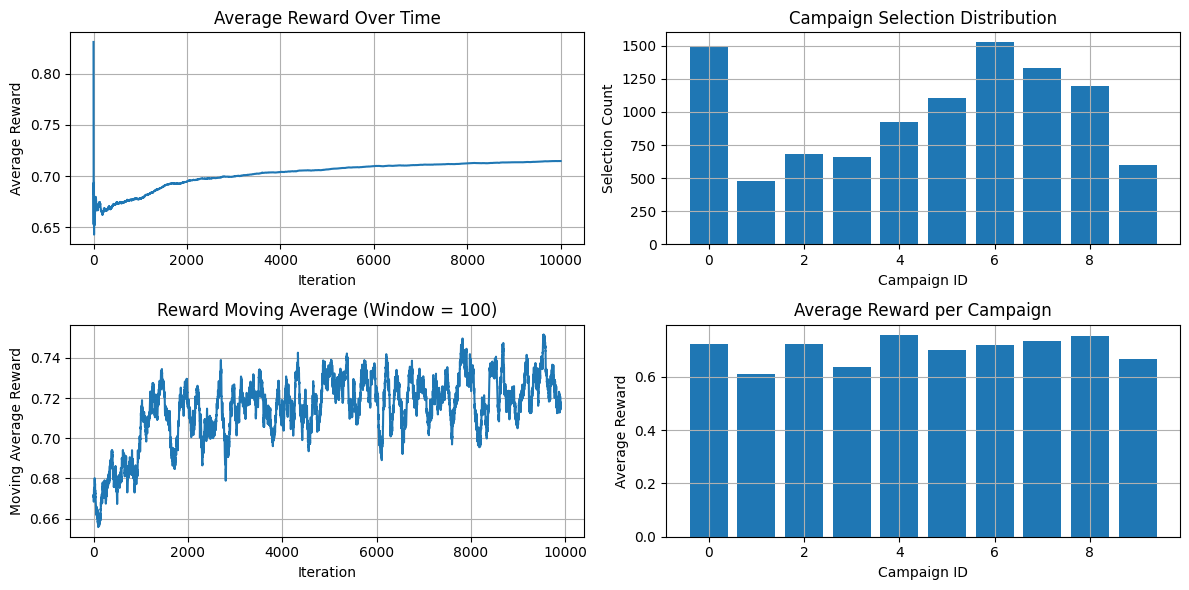


===== EVALUATING FOR NEW USERS =====
Average Random Reward: 0.6636
Average Bandit Reward: 0.7054
Improvement: 6.30%


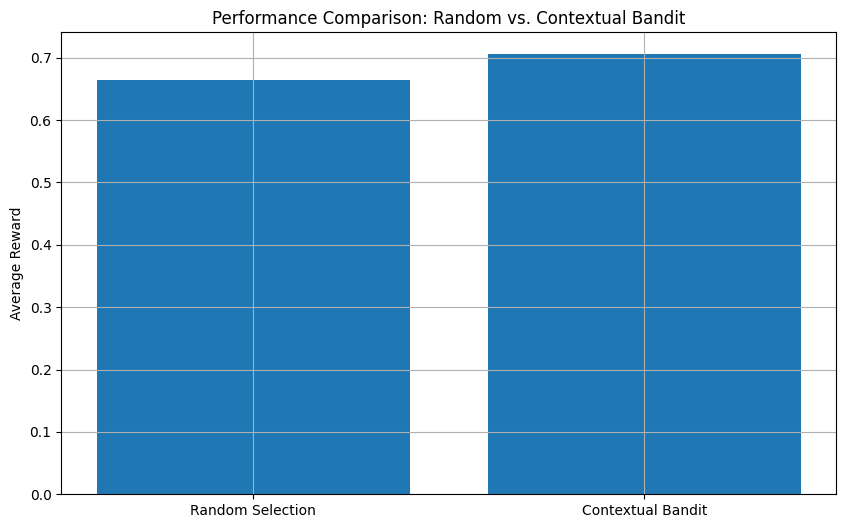


===== CAMPAIGN INSIGHTS =====
Campaign 0: Top Genres = Drama, Comedy, Action, Avg Reward = 0.7249, Selection Count = 1496
Campaign 1: Top Genres = (no genres listed), Action, Animation, Avg Reward = 0.6103, Selection Count = 477
Campaign 2: Top Genres = Drama, Comedy, Thriller, Avg Reward = 0.7228, Selection Count = 686
Campaign 3: Top Genres = Drama, Comedy, Romance, Avg Reward = 0.6366, Selection Count = 660
Campaign 4: Top Genres = Drama, Comedy, Thriller, Avg Reward = 0.7574, Selection Count = 928
Campaign 5: Top Genres = Drama, Comedy, Romance, Avg Reward = 0.7001, Selection Count = 1102
Campaign 6: Top Genres = Drama, Comedy, Romance, Avg Reward = 0.7213, Selection Count = 1526
Campaign 7: Top Genres = Drama, Comedy, Action, Avg Reward = 0.7363, Selection Count = 1330
Campaign 8: Top Genres = Comedy, Drama, Action, Avg Reward = 0.7542, Selection Count = 1199
Campaign 9: Top Genres = Comedy, Drama, Action, Avg Reward = 0.6655, Selection Count = 596

Best-performing campaign: 4
To

In [ ]:
# ===================== RESULTS VISUALIZATION ===================== #
print("\n===== VISUALIZING RESULTS =====")

# Plot reward history
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(avg_rewards_history)
plt.title('Average Reward Over Time')
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.grid(True)

# Plot arm selection distribution
plt.subplot(2, 2, 2)
plt.bar(range(n_campaigns), arm_selection_counts)
plt.title('Campaign Selection Distribution')
plt.xlabel('Campaign ID')
plt.ylabel('Selection Count')
plt.grid(True)

# Plot reward moving average
window_size = 100
rewards_ma = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
plt.subplot(2, 2, 3)
plt.plot(rewards_ma)
plt.title(f'Reward Moving Average (Window = {window_size})')
plt.xlabel('Iteration')
plt.ylabel('Moving Average Reward')
plt.grid(True)

# Plot campaign performance
campaign_rewards = defaultdict(list)
for i in range(len(rewards_history)):
    campaign_rewards[selected_arms_history[i]].append(rewards_history[i])

campaign_avg_rewards = [np.mean(rewards) if rewards else 0 for campaign, rewards in sorted(campaign_rewards.items())]

plt.subplot(2, 2, 4)
plt.bar(range(n_campaigns), campaign_avg_rewards)
plt.title('Average Reward per Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Average Reward')
plt.grid(True)

plt.tight_layout()
plt.savefig('contextual_bandit_results.png')
plt.show()

# ===================== EVALUATION FOR A NEW USER ===================== #
print("\n===== EVALUATING FOR NEW USERS =====")

def evaluate_random_vs_bandit(simulator, linucb, n_users=100):
    """
    Compare random selection vs. contextual bandit for new users

    Parameters:
    - simulator: simulation environment
    - linucb: trained LinUCB policy
    - n_users: number of users to evaluate

    Returns:
    - random_rewards: rewards from random selection
    - bandit_rewards: rewards from contextual bandit
    """
    random_rewards = []
    bandit_rewards = []

    # Sample users
    sample_user_ids = np.random.choice(user_ids, n_users)

    for user_id in sample_user_ids:
        # Get context for this user
        context = simulator.get_user_context(user_id)

        # Random selection
        random_arm = np.random.randint(0, n_campaigns)
        random_reward = simulator.get_reward(user_id, random_arm)
        random_rewards.append(random_reward)

        # Bandit selection
        bandit_arm, _, _ = linucb.select_arm(context)
        bandit_reward = simulator.get_reward(user_id, bandit_arm)
        bandit_rewards.append(bandit_reward)

    return random_rewards, bandit_rewards

# Evaluate
random_rewards, bandit_rewards = evaluate_random_vs_bandit(simulator, linucb)

# Calculate average rewards
avg_random_reward = np.mean(random_rewards)
avg_bandit_reward = np.mean(bandit_rewards)
improvement = (avg_bandit_reward - avg_random_reward) / avg_random_reward * 100

print(f"Average Random Reward: {avg_random_reward:.4f}")
print(f"Average Bandit Reward: {avg_bandit_reward:.4f}")
print(f"Improvement: {improvement:.2f}%")

# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(['Random Selection', 'Contextual Bandit'],
        [avg_random_reward, avg_bandit_reward])
plt.title('Performance Comparison: Random vs. Contextual Bandit')
plt.ylabel('Average Reward')
plt.grid(True)
plt.savefig('performance_comparison.png')
plt.show()

# Generate campaign insights
print("\n===== CAMPAIGN INSIGHTS =====")

# Map campaigns to top genres
campaign_genres = {}
for campaign_id in range(n_campaigns):
    # Get movies in this campaign
    movie_ids = simulator.campaign_movies[campaign_id]
    campaign_movies = movies_df[movies_df['movieId'].isin(movie_ids)]

    # Calculate the most common genres
    genre_counts = {}
    for genre in genres:
        genre_col = f'genre_{genre}'
        if genre_col in campaign_movies.columns:
            count = campaign_movies[genre_col].sum()
            genre_counts[genre] = count

    # Sort genres by count
    top_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)[:3]
    campaign_genres[campaign_id] = [genre for genre, _ in top_genres]

    print(f"Campaign {campaign_id}: Top Genres = {', '.join(campaign_genres[campaign_id])}, "
          f"Avg Reward = {campaign_avg_rewards[campaign_id]:.4f}, "
          f"Selection Count = {arm_selection_counts[campaign_id]}")

# Print top-performing campaign
best_campaign = np.argmax(campaign_avg_rewards)
print(f"\nBest-performing campaign: {best_campaign}")
print(f"Top genres: {', '.join(campaign_genres[best_campaign])}")
print(f"Average reward: {campaign_avg_rewards[best_campaign]:.4f}")
print(f"Selection count: {arm_selection_counts[best_campaign]}")

print("\n===== SIMULATION COMPLETE =====")